<a href="https://colab.research.google.com/github/stefsyrsiri/synthetic-image-detection/blob/agalanopoulou/Copy_of_Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In progress** Deep learning project for the "Deep Learning" course of the MSc "Data Science".

In [3]:
# Project overview
# 1. CNN
# 2. Transfer learning

In [33]:
# Import packages
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms,models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode,v2
import cv2
torch.manual_seed(42)
from sklearn.manifold import TSNE
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.v2 as v2_transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


# import tensorflow
# from tensorflow.keras import Model #Model class for instantiating the ResNet that you will be creating.


# #These are all described in standard deep learning literature (e.g. Conv2Dor Dense). Why they are necessary can be found in the He et al. (2016) paper.
# from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
#  Dense, Flatten, Conv2D, Lambda, Input, BatchNormalization, Activation

# #schedules and the Stochastic Gradient Descent optimizer for optimization purposes.
# from tensorflow.keras.optimizers import schedules, SGD

# #for visualizing your training results and saving your model, respectively.
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


In [ ]:
# Datasets
# We have 2 candidate datasets with real and synthetic images
# CIFAKE: Real and AI-Generated Synthetic Images
# https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
#
# ArtiFact (no kaggle url - only kaggle API)
# !kaggle datasets download -d awsaf49/artifact-dataset
# We should also import and take a look at ArtiFact to see which dataset we prefare
# Took a look at ArtiFact. Much much bigger dataset with a lot datasets inside. Let's work with the simpler dataset first and try the other one if we have enough time.
#
# Using a kaggle key for now. Also using an input function to avoid storing the key in the code
# Whoever wants to run their code has to input their own key (Stef/Anna/TG) - we can change this later
KAGGLE_USERNAME = input("Enter your Kaggle username: ")
KAGGLE_KEY = input("Enter your Kaggle key: ")

os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [6]:
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 93% 97.0M/105M [00:00<00:00, 127MB/s]
100% 105M/105M [00:00<00:00, 130MB/s] 


In [7]:
# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

In [8]:
!ls

cifake-real-and-ai-generated-synthetic-images.zip  sample_data	test  train


In [9]:
!find . -type d

.
./.config
./.config/configurations
./.config/logs
./.config/logs/2024.06.11
./train
./train/FAKE
./train/REAL
./test
./test/FAKE
./test/REAL
./sample_data


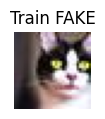

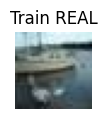

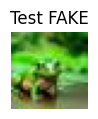

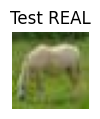

In [10]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[6])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [11]:
# Classes' labels
LABELS = np.asarray(os.listdir('train'))
print(LABELS)

['FAKE' 'REAL']


In [ ]:
# Observe the number of images for each class in testset
real_count_train = sum(label == 0 for label in trainset.targets)
fake_count_train = sum(label == 1 for label in trainset.targets)

# Define labels and counts
labels = ['Real', 'Fake']
test_counts = [real_count_train, fake_count_train]

# Define bar width
bar_width = 0.35

# Set up the bar chart
fig, ax = plt.subplots()
index = range(len(labels))

# Plot test set counts
bar1 = ax.bar(index, test_counts, bar_width, label='Training Set')

# Add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Images for Each Class in Train Set')
ax.set_xticks([i for i in index])
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()

In [12]:
# Create the training and test datasets with ImageFolder class from PyTorch in comparison to creating custom datasets
# TODO: Add transformation
# Training dataset
train_dataset = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set:\n{train_dataset}\n")

# Validation dataset
test_set  = datasets.ImageFolder(root='test')
print(f"Test set:\n{test_set}")

Training set:
Dataset ImageFolder
    Number of datapoints: 100000
    Root location: train

Test set:
Dataset ImageFolder
    Number of datapoints: 20000
    Root location: test


Applying transformations and visualizing them helps ensure that the data preprocessing
and augmentation pipeline is correctly implemented.
It also ensures that the transformations are enhancing the dataset in a way that will help the model generalize better to new data,
ultimately improving the model's performance and robustness.

Split the dataset to 80/20

In [13]:
len_img=len(train_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_dataset,val_dataset=random_split(train_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_dataset))
print("validation dataset size:", len(val_dataset))

train dataset size: 80000
validation dataset size: 20000


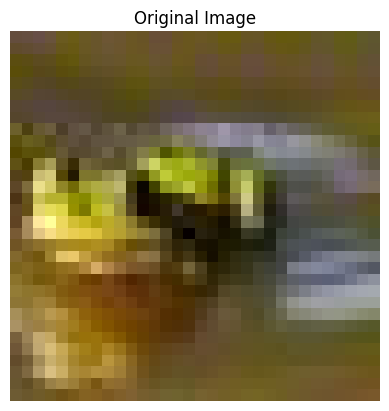

In [14]:
img, label = val_dataset[2]

# Convert PIL Image to numpy array
img_np = np.array(img)

# Visualize the original image
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image")
plt.show()

The preprocessing for validation dataset

In [15]:
Val_transform = v2_transforms.Compose([
    # Resize image to 232 x 232
    # All images have a uniform size, which is required for batch processing in neural networks
    v2_transforms.Resize(size=(232, 232), interpolation=InterpolationMode.BILINEAR, antialias=True),

    # Ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.
    v2_transforms.CenterCrop(224),

    # Converts the image from a PIL Image or numpy array to a tensor.
    # Changes the data range from [0, 255] to [0.0, 1.0].
    v2_transforms.ToImage(),
    v2_transforms.ToDtype(torch.float32, scale=True),

    # Applies the normalization operation to each channel using the specified mean and standard deviation.
    # Uncomment the following line if you want to include normalization.
    # v2_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [16]:
# Load the validation dataset and apply the transformation
val_dataset.dataset.transform = Val_transform

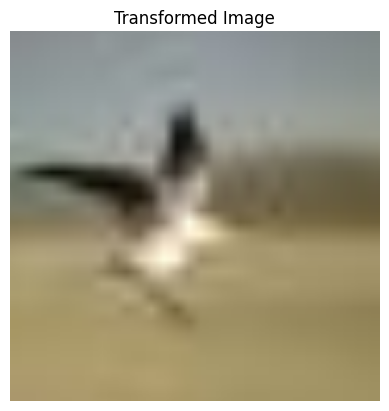

In [17]:

img, label = val_dataset[1]

Val_transformed_img = Val_transform(img)

# Convert PyTorch tensor to numpy array and rearrange dimensions
Val_transformed_img_np = np.transpose(Val_transformed_img .numpy(), (1, 2, 0))

# Convert PyTorch tensor to numpy array and rearrange dimensions
img_np = np.transpose(img.numpy(), (1, 2, 0))

# Visualize the transformed image
plt.imshow(Val_transformed_img_np)
plt.axis('off')
plt.title("Transformed Image")
plt.show()


ugmentation techniques (e.g., random rotations, flips, color jittering) are typically applied only to the training set. The purpose of data augmentation is to artificially expand the training dataset and help the model generalize better by learning from varied examples. Augmentation should not be applied to the validation set because it should represent the true distribution of data the model will encounter in real-world scenarios.

In [18]:
Train_transform = v2.Compose([
    # resize image to 232 x 232
    ## all images have a uniform size, which is required for batch processing in neural networks
    v2.Resize(size=(232, 232), interpolation=InterpolationMode.BILINEAR, antialias=True),

    ##ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.
    v2.CenterCrop(224),

    # data augmentation

    ##Flips the image horizontally with a probability of 0.5. This helps the model become invariant to the horizontal orientation of objects, increasing its robustness.
    v2.RandomHorizontalFlip(p=0.5),

    ##Rotates the image by up to 30 degrees randomly. This adds variation to the dataset, helping the model learn to recognize objects from different angles.
    v2.RandomRotation(degrees=30),

    ##Randomly changes the brightness and contrast of the image, simulating different lighting conditions. This makes the model more robust to changes in lighting in real-world scenarios.
    v2.ColorJitter(brightness=.3, contrast = 0.3),

    ## Randomly permutes the RGB channels, which can help the model become invariant to color variations. This is especially useful if color is not a crucial feature for classification.
    v2.RandomChannelPermutation(),
    # convert PIL image to tensor with image values in [0, 1]

    v2.ToTensor(),

    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [19]:
# Load the train dataset and apply the transformation
train_dataset.dataset.transform = Train_transform

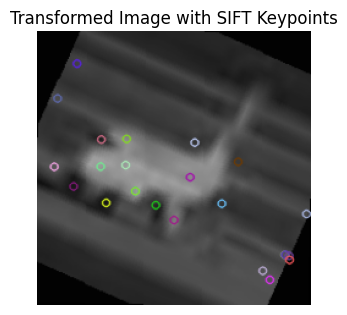

In [20]:


img, label = train_dataset[1]

Train_transformed_img = Train_transform(img)

# Convert PyTorch tensor to numpy array and rearrange dimensions
Train_transformed_img_np = np.transpose(Train_transformed_img.numpy(), (1, 2, 0))


# Convert to uint8 for OpenCV
Train_transformed_img_np_uint8 = (Train_transformed_img_np * 255).astype(np.uint8)


# Convert the transformed image to a tensor and add a batch dimension
#Train_transformed_img = transforms.ToTensor()(Train_transformed_img)
Train_transformed_img = Train_transformed_img.unsqueeze(0)

#-----------------------------------------------------------#

#Εδω κανουμε με resnet feature extraction , το κανω remark για να το δουμε στο Transfer learning!#

# # Load a pretrained ResNet model (Residual Network)
#  model = models.resnet50(pretrained=True)

# feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# # # Ensure the model is in evaluation mode
# feature_extractor.eval()

# # # Extract features
# with torch.no_grad():features = feature_extractor(Train_transformed_img).squeeze()

# # # Convert features to a numpy array for further processing if needed
# features_np = features.numpy()

#------------------------------------------------------------#

# # Convert the transformed image to numpy array for SIFT
Train_transformed_img = Train_transformed_img.squeeze().permute(1, 2, 0).numpy()
Train_transformed_img = np.clip((Train_transformed_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])), 0, 1)
Train_transformed_img = (Train_transformed_img * 255).astype(np.uint8)



# ##Scale-Invariant Feature Transform (SIFT) algorithm to detect and visualize keypoints in a grayscale version of the image. --SIFT works on single-channel images, so the RGB image is converted to grayscale.
gray = cv2.cvtColor(Train_transformed_img_np_uint8, cv2.COLOR_RGB2GRAY)


# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints
key_points = sift.detect(gray, None)

# Draw keypoints on the image
img_with_kp = cv2.drawKeypoints(gray, key_points, None)

# Create a figure
fig = plt.figure(figsize=(12, 6))

# Convert image from BGR to RGB for matplotlib
img_rgb = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

fig.add_subplot(1, 3, 3)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Transformed Image with SIFT Keypoints")
plt.show()



In [21]:
# Feature engineering

In [56]:
# Batch size - change if we get an Out Of Memory error
BATCH_SIZE = 4

# Training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
valid_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

# Test data loaders
Test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)



In [69]:
# Neural net architecture
# TG said that we should save our classes to another file and import them for the report
#It has two convolutional layers (conv1 and conv2) with ReLU activation functions,
#followed by max pooling layers (pool).
#The fully connected layers (fc1, fc2, and fc3) process the output of the convolutional layers.

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) ## (input channel size ( based on color channels of the image), output channel size, kernel size)
        self.pool = nn.MaxPool2d(2, 2) ## (kernel size ,stride)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


# The forward method defines the forward pass of the network,
# where input x is passed through each layer sequentially.
# The view method reshapes the output of the second convolutional layer to be compatible
# with the fully connected layers. Finally,
#  an instance of the Net class is created as net, representing the neural network model.

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN()

In [54]:
# for classification tasks calculates the loss between the predicted class probabilities and the actual class labels.
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [64]:
# Here we check if the batch size is diffent than the input

# Iterate over the train_loader
for i, data in enumerate(train_loader):
    inputs, labels = data

    # Check if batch size is different from 4
    if inputs.size(0) != 4 or labels.size(0) != 4:
        print(f"Batch {i + 1} has a different batch size: Input batch size: {inputs.size(0)}, Labels batch size: {labels.size(0)}")



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0 #is initialized to zero at the beginning of each epoch to keep track of the cumulative loss.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

# This clears the gradients of all optimized parameters.
# Gradients need to be reset to zero before starting
# backpropagation because PyTorch accumulates gradients on subsequent backward passes.
        optimizer.zero_grad()

#This line passes the inputs through the model to get the outputs
        outputs = model(inputs)
#  The loss (error) between the model's
#  outputs and the actual labels is computed using a loss function (criterion).

        loss = criterion(outputs, labels)
# This computes the gradient of the loss
# with respect to the model parameters (weights and biases) via backpropagation.
        loss.backward()
# This updates the model parameters based on the computed gradients.
# The optimizer adjusts the parameters to minimize the loss.

        optimizer.step()

# Every 2000 mini-batches, the average loss is printed.
# This provides feedback on the training process.

        running_loss += loss.item()
        if i % 20000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

Total Iterations per Epoch:Given the training set size of 80,000 and a batch size of 64, the total number of iterations (mini-batches) per epoch is:

total_iterations = total_samples / batch_Size =
80000/64 = 1250
​

Printing Frequency:

You want to balance between too frequent and too infrequent logging. If you print too often, it might clutter the output and slightly slow down training due to I/O operations. If you print too infrequently, you might not get enough information to monitor training effectively.
A common approach is to print the running loss a few times per epoch.

For an 80,000-sample training set and a batch size of 64, a good approach could be to print the loss every 200 mini-batches. This way, you'll get around 6 updates per epoch (1250 iterations / 200 = 6.25), which provides a good balance between feedback frequency and performance overhead.

In [ ]:
# Transfer learning